# A. Extending the Optimization Routines and Loss Functions

In the previous assignment we implemented a class for Optimization. Extend the class with an additional functionality for adapting the step-length.
1. Bold-Driver Step Length (slide 23/37)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import collections

In [3]:
class Optimization():
    def __init__(self,X,y,loss):
        self.X = X
        self.y = y
        self.loss = loss
    # BOLD DRIVER IMPLEMENTATION    
    def bold_driver(self,loss_old,loss_new,mew_old,mew_plus,mew_minus):
        if loss_new>loss_old:
            mu = mew_old*mew_minus
        else:
            mu = mew_old*mew_plus
        return mu
    # SGD IMPLEMENTATION
    def min_sgd(self, theta0, mu, C, K, epsilon):
        theta = theta0
        J_hist = np.zeros((K,1))
        theta_val = np.zeros((K,self.X.shape[1]))
        for i in range(K):
            for j in range(C):
                index = np.random.randint(len(self.y))
                xvar = self.X[index:index+1]
                yvar = self.y[index:index+1]
                losses, gradient, _ = self.loss(self, xvar, yvar,theta)
                J_hist[i] += losses.ravel()
                mu = self.bold_driver(J_hist[i-1],J_hist[i],mu,0.01,0.5)
                theta = theta - mu*gradient
                if np.all(np.abs(gradient**2) <= epsilon):
                    break     
            J_hist[i] /= C       
            theta_val[i] = theta.reshape(1,self.X.shape[1])
        return J_hist, theta_val, theta
    # COMPUTING WEIGHT FOR BALANCED CROSS ENTROPY LOSS
    def computeWeight(self,y):
        
        labels = np.array(y)
        
        N = labels.shape[0]
        
        positive_samples = np.sum(labels,axis = 0)

        negative_samples = N - positive_samples
        # print("Ones:",positive_samples)
        # print("Zeros:",negative_samples)
        w0 = N/(2*negative_samples)
        w1 = N/(2*positive_samples)
        
        return w0,w1                                   

Extend the Loss class implemented in the previous exercise with the following capabilities.
1. Case Weights (slide 33/37): Implement an additional balanced-cross-entropy loss function that takes care of the class imbalance within the dataset, by applying proportionally higher case weights to the minority class.
2. Regularization (slide 10/29): Implement L1-reg-cross-entropy and L2-reg-cross-entropy for L1 regularized and L2 regularized versions of the basic cross-entropy loss function.
For the optimization process, you would also need functions that calculate gradients for the same.


In [4]:
class Loss():
    def __init__(self, X, y):
        super().__init__()
    # CROSS ENTROPY LOSS
    def cross_entropy(self, X,y, theta):
        M = len(y)
        p = 1/(1+np.exp(-X@theta))
        W = np.diag((p*(1-p)).reshape(-1))
        return -1/M*(y.T@np.log(p) + (1-y).T@np.log((1-p))),-X.T.dot(y - p), X.T@W@X   
    # BALANCED CROSS ENTROPY LOSS
    def balanced_cross_entropy(self, X,y, theta):
        M = len(y)
        p = 1/(1+np.exp(-X@theta))
        W = np.diag((p*(1-p)).reshape(-1))
        classweight0,classweight1 = self.computeWeight(y)
        # return -1/M*(1.34*y.T@np.log(p) + 0.79*(1-y).T@np.log((1-p))),-X.T.dot(y - p), X.T@W@X
        return -1/M*(classweight0*y.T@np.log(p) + classweight1*(1-y).T@np.log((1-p))),-X.T.dot(y - p), X.T@W@X
    # L1 REGULARIZATION
    def l1(self, X,y, theta):
        lamda = 0.1
        M = len(y)
        p = 1/(1+np.exp(-X@theta))
        W = np.diag((p*(1-p)).reshape(-1))
        return -1/M*(y.T@np.log(p) + (1-y).T@np.log((1-p)) + lamda*abs(np.sum(theta))),-X.T.dot(y - p), X.T@W@X
    # L2 REGULARIZATION
    def l2(self, X,y, theta):
        lamda = 0.1
        M = len(y)
        p = 1/(1+np.exp(-X@theta))
        W = np.diag((p*(1-p)).reshape(-1))
        return -1/M*(y.T@np.log(p) + (1-y).T@np.log((1-p)) + lamda*np.dot(theta.T,theta)),-X.T.dot(y - p), X.T@W@X


In [5]:
class LogisticRegression:
    def fit(self, X, y, learning_rate = 0.01, maxiter = 100, batch_size = 100, tolerance = 10e-5, optimizer = 'SGD'):
        theta0 = np.zeros((X.shape[1],1))
        
        if optimizer == 'SGD':
            optimization = Optimization(X, y, loss = Loss.cross_entropy)
            J_hist, theta_val, theta  = optimization.min_sgd(theta0 = theta0,mu = learning_rate, C = batch_size,K = maxiter, epsilon= tolerance)
            # AIC = 2*31 - 2*J_hist[-1]
            # print("AIC is:",AIC)
        elif optimizer == 'BCE':
            optimization = Optimization(X, y, loss = Loss.balanced_cross_entropy)
            J_hist, theta_val, theta  = optimization.min_sgd(theta0 = theta0,mu = learning_rate, C = batch_size,K = maxiter, epsilon= tolerance)
        elif optimizer == 'l1':
            optimization = Optimization(X, y, loss = Loss.l1)
            J_hist, theta_val, theta  = optimization.min_sgd(theta0 = theta0,mu = learning_rate, C = batch_size,K = maxiter, epsilon= tolerance)
        elif optimizer == 'l2':
            optimization = Optimization(X, y, loss = Loss.l2)
            J_hist, theta_val, theta  = optimization.min_sgd(theta0 = theta0,mu = learning_rate, C = batch_size,K = maxiter, epsilon= tolerance)           
        else: raise Exception("Please enter optimizer's name correctly: 'SGD' or 'Newton'")  
        self.theta = theta
        self.J_hist = J_hist
        self.theta_val = theta_val
        return theta,theta_val,J_hist
    
    # Prediction using sigmoid function 
    def predict(self, X, class_prob = False):
        if class_prob == True:
            return 1/(1+np.exp(-X@self.theta))
        else:
            return ((1/(1+np.exp(-X@self.theta)))>= 0.5).astype(int)
        return pred
    
    # Plotting the loss for training and testing sets
    def plot_loss(self, X, y):
        J_hist_pred = np.zeros((self.theta_val.shape[0],1))
        for i in range(self.theta_val.shape[0]):
            temp_theta = self.theta_val[i,:]
            p = 1/(1+np.exp(-X@temp_theta))
            J_hist_pred[i] = -1/len(y)*(y.T@np.log(p) + (1-y).T@np.log((1-p)))
        f, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
        sns.set_style('white')
        ax0.plot(range(len(self.J_hist)), self.J_hist, 'blue')
        ax0.set_title("Cost Function of Train")
        ax0.set_xlabel("Number of Iterations")
        ax0.set_ylabel("Cost")
        ax1.plot(range(len(J_hist_pred)), J_hist_pred, 'red')
        ax1.set_title("Cost Function of Test")
        ax1.set_xlabel("Number of Iterations")
        ax1.set_ylabel("Cost")
        plt.show()
    
    # Plotting the confusion matrix along with the accuracy
    def plot_metrics(self, y_true, y_pred):
        fp, fn, tp, tn = 0, 0, 0, 0
        for true, pred in zip(y_true, y_pred):
            if pred == true:
                if pred == 1: tp +=1
                else: tn+=1
            else:
                if pred == 1: fp +=1
                else: fn+=1
        confusion_matrix = np.array([[tp,fp], [fn, tn]])
        accuracy = np.round((tp+tn)/len(y_true),3)
        precision = np.round(tp/(tp+fp),3)
        recall = np.round(tp/(tp+fn),3)
        f1 = np.round((2*(precision*recall))/(precision + recall),3)
        print('-----------------------------------------------------------------------------------------------')
        print('|',f'Accuracy: {accuracy}','|' ,f'Recall: {recall}', ' |')
        print('|',f'Precision: {precision}','|', f'F1-score: {f1}', '|' )
        print('-----------------------------------------------------------------------------------------------')
        
        plt.figure(figsize=(10,7))
        sns.set(font_scale=1.4) 
        labels = ['1','0']
        sns.heatmap(confusion_matrix, annot=True, annot_kws={"size": 12}, fmt='g', xticklabels=labels, yticklabels=labels)
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title('Confusion Matrix')
        plt.show()
        
        
        
    

In [6]:
# Reading the dataset
logistic = pd.read_csv('logistic.csv')
# Choosing all the feature columns
X = logistic.loc[:,'X1':'X30']
# Assigning the target variable
y = logistic.Y
# Standardizing the entire dataset
x_scaled = (np.array(X) - np.mean(X, axis = 0).ravel())/(np.std(X,axis = 0).ravel())
# Adding a ones column for the bias component in the model
x_scaled = np.hstack((np.ones((x_scaled.shape[0],1)),x_scaled))
# print(x_scaled)
# Changing the categorical variables into binary 0,1 
mapping = {'M':1, 'B':0}
y = y.map(mapping)

np.random.seed(0)
# Splitting the dataset into 80:20 ratio 
mask = np.random.rand(len(x_scaled)) <= 0.80
training_data = x_scaled[mask]
testing_data = x_scaled[~mask]
training_y = y[mask]
testing_y = y[~mask]
print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")
training_y = training_y[:, np.newaxis]
testing_y = testing_y[:, np.newaxis]

No. of training examples: 458
No. of testing examples: 111


# B. Regularization and Model Selection
In this task, you work with the same data set as before, named ‘logistic.csv‘. Use the previous implementation of class LogisticRegression for fitting a logistic regression model and predicting the results. Fit a logistic regression model with the following pair:

Below with the following combinations of loss and SGD method we observe how the accuracy and other measures changes.

### 1. Cross Entropy Loss and Stochastic Gradient Descent.

 
 Logistic Regression Model with Cross Entropy Loss and SGD:
 

 Training Set Results:

-----------------------------------------------------------------------------------------------
| Accuracy: 0.841 | Recall: 0.892  |
| Precision: 0.744 | F1-score: 0.811 |
-----------------------------------------------------------------------------------------------


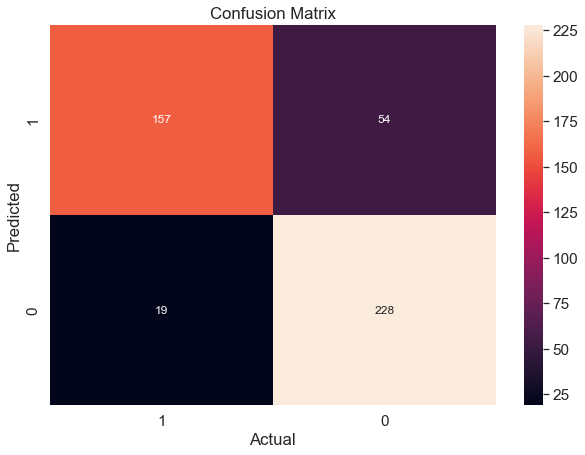


 Testing Set Results:

-----------------------------------------------------------------------------------------------
| Accuracy: 0.829 | Recall: 0.889  |
| Precision: 0.681 | F1-score: 0.771 |
-----------------------------------------------------------------------------------------------


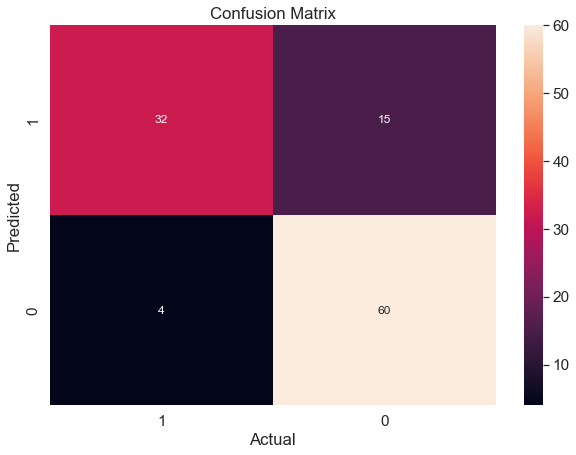

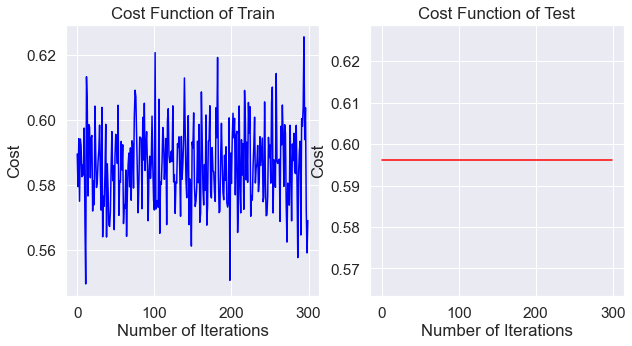

In [7]:
log_reg = LogisticRegression()
theta,theta_val,J_hist = log_reg.fit(training_data, training_y,  learning_rate = 0.1, maxiter = 300, batch_size = 100, tolerance = 10e-5, optimizer = 'SGD')
# print("Number of paramters :", theta.shape)
pred_log = log_reg.predict(testing_data, class_prob = True)
# print(pred_log)
pred_log_train= log_reg.predict(training_data)
# print(pred_log_train)
print(" \n Logistic Regression Model with Cross Entropy Loss and SGD:\n ")
print("\n Training Set Results:\n")
log_reg.plot_metrics(training_y,pred_log_train)
pred_log = log_reg.predict(testing_data)
print("\n Testing Set Results:\n")
log_reg.plot_metrics(testing_y,pred_log)
log_reg.plot_loss(testing_data,testing_y)
# len(theta)


### 2. Balanced Cross Entropy Loss and Stochastic Gradient Descent.

 
 Logistic Regression Model with Balanced Cross Entropy Loss and SGD:
 

 Training Set Results:

-----------------------------------------------------------------------------------------------
| Accuracy: 0.845 | Recall: 0.869  |
| Precision: 0.761 | F1-score: 0.811 |
-----------------------------------------------------------------------------------------------


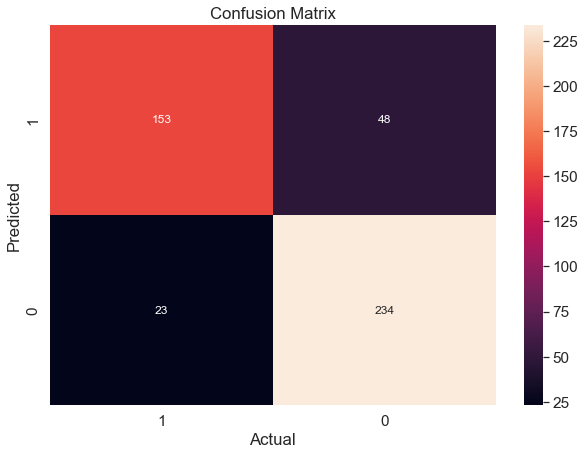


 Testing Set Results:

-----------------------------------------------------------------------------------------------
| Accuracy: 0.838 | Recall: 0.833  |
| Precision: 0.714 | F1-score: 0.769 |
-----------------------------------------------------------------------------------------------


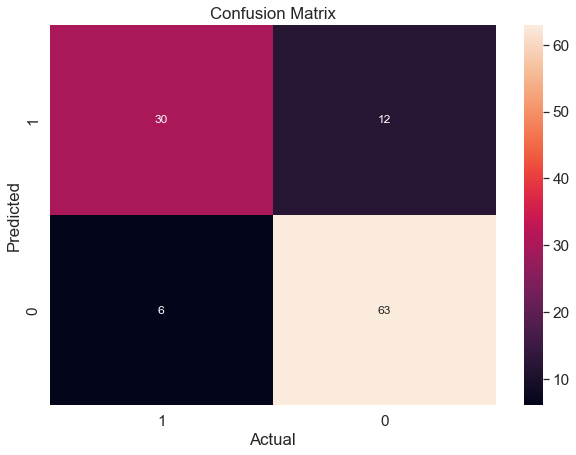

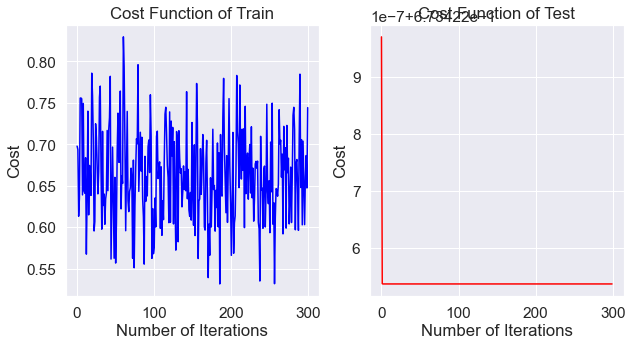

In [8]:
log_reg1 = LogisticRegression()
theta1 = log_reg1.fit(training_data, training_y,  learning_rate = 0.01, maxiter = 300, batch_size = 10, tolerance = 10e-5, optimizer = 'BCE')
pred_log1 = log_reg1.predict(testing_data, class_prob = True)
pred_log_train1= log_reg1.predict(training_data)
print(" \n Logistic Regression Model with Balanced Cross Entropy Loss and SGD:\n ")
print("\n Training Set Results:\n")
log_reg1.plot_metrics(training_y,pred_log_train1)
pred_log1 = log_reg1.predict(testing_data)
print("\n Testing Set Results:\n")
log_reg1.plot_metrics(testing_y,pred_log1)
log_reg1.plot_loss(testing_data,testing_y)

### 3. L1-Regularized Cross Entropy Loss and Stochastic Gradient Descent.

 
 Logistic Regression Model with L1_regularized Cross Entropy Loss and SGD:
 

 Training Set Results:

-----------------------------------------------------------------------------------------------
| Accuracy: 0.937 | Recall: 0.949  |
| Precision: 0.893 | F1-score: 0.92 |
-----------------------------------------------------------------------------------------------


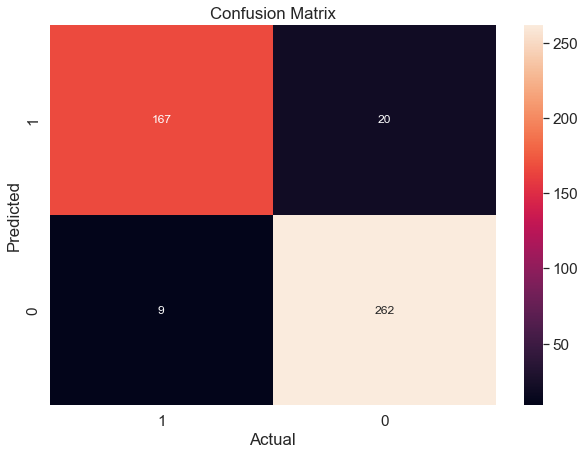


 Testing Set Results:

-----------------------------------------------------------------------------------------------
| Accuracy: 0.928 | Recall: 0.917  |
| Precision: 0.868 | F1-score: 0.892 |
-----------------------------------------------------------------------------------------------


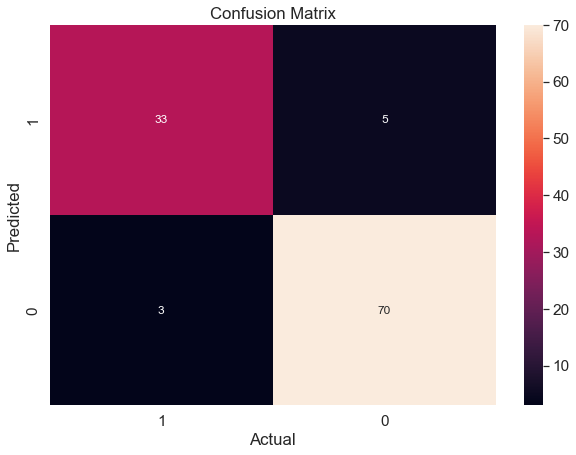

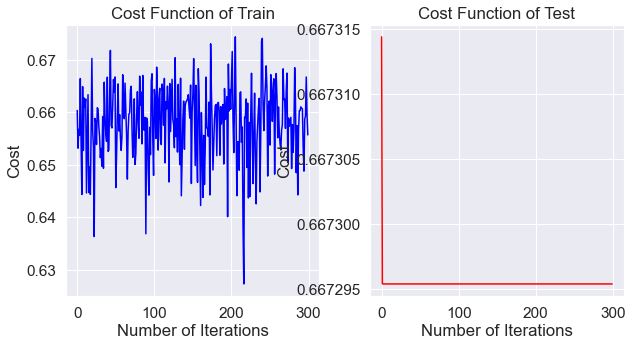

In [9]:
log_reg2 = LogisticRegression()
theta2 = log_reg2.fit(training_data, training_y,  learning_rate = 0.01, maxiter = 300, batch_size = 10, tolerance = 10e-5, optimizer = 'l1')
pred_log2 = log_reg2.predict(testing_data, class_prob = True)
pred_log_train2= log_reg2.predict(training_data)
print(" \n Logistic Regression Model with L1_regularized Cross Entropy Loss and SGD:\n ")
print("\n Training Set Results:\n")
log_reg2.plot_metrics(training_y,pred_log_train2)
pred_log2 = log_reg2.predict(testing_data)
print("\n Testing Set Results:\n")
log_reg2.plot_metrics(testing_y,pred_log2)
log_reg2.plot_loss(testing_data,testing_y)

### 4. L2-Regularized Cross Entropy Loss and Stochastic Gradient Descent.

 
 Logistic Regression Model with L2-Regularized Cross Entropy Loss and SGD:
 

 Training Set Results:

-----------------------------------------------------------------------------------------------
| Accuracy: 0.871 | Recall: 0.892  |
| Precision: 0.797 | F1-score: 0.842 |
-----------------------------------------------------------------------------------------------


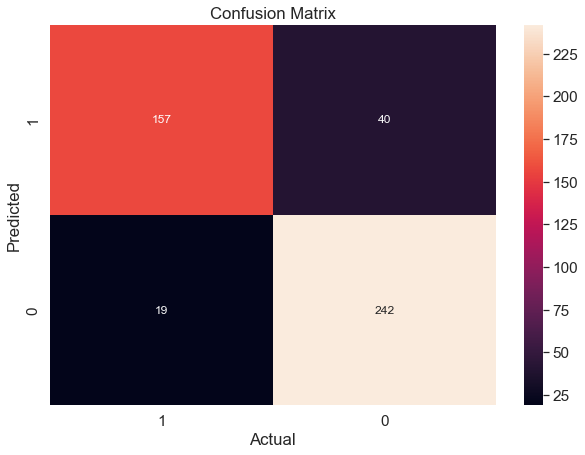


 Testing Set Results:

-----------------------------------------------------------------------------------------------
| Accuracy: 0.856 | Recall: 0.833  |
| Precision: 0.75 | F1-score: 0.789 |
-----------------------------------------------------------------------------------------------


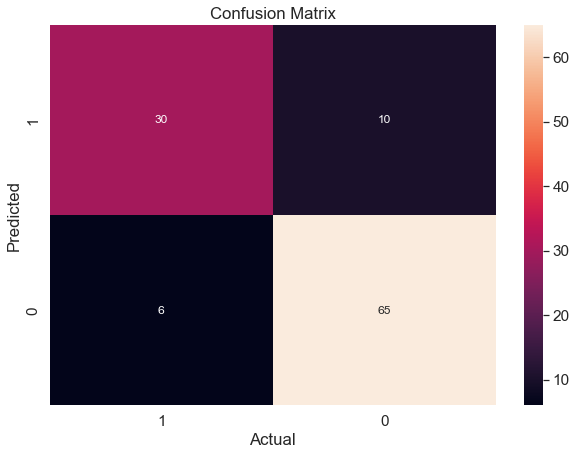

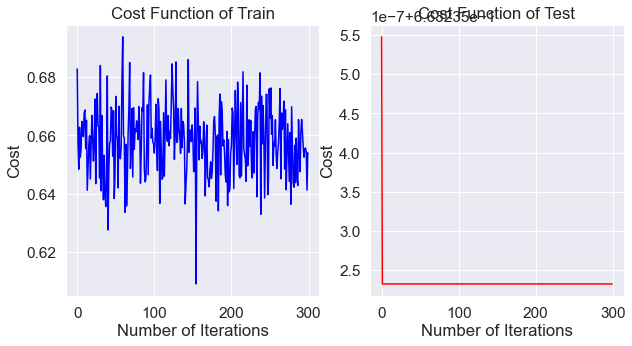

In [10]:
log_reg4 = LogisticRegression()
theta4 = log_reg4.fit(training_data, training_y,  learning_rate = 0.01, maxiter = 300, batch_size = 10, tolerance = 10e-5, optimizer = 'l2')
pred_log4 = log_reg4.predict(testing_data, class_prob = True)
pred_log_train4= log_reg4.predict(training_data)
print(" \n Logistic Regression Model with L2-Regularized Cross Entropy Loss and SGD:\n ")
print("\n Training Set Results:\n")
log_reg4.plot_metrics(training_y,pred_log_train4)
pred_log4 = log_reg4.predict(testing_data)
print("\n Testing Set Results:\n")
log_reg4.plot_metrics(testing_y,pred_log4)
log_reg4.plot_loss(testing_data,testing_y)

#### Checking using built in package

In [17]:
import statsmodels.api as sm 

regressor_OLS = sm.OLS(endog = training_y, exog = training_data).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     51.76
Date:                Sun, 04 Dec 2022   Prob (F-statistic):          1.51e-122
Time:                        13:08:35   Log-Likelihood:                 31.475
No. Observations:                 458   AIC:                           -0.9508
Df Residuals:                     427   BIC:                             127.0
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3751      0.011     33.963      0.000       0.353       0.397
x1            -1.1939      0.692     -1.725      0.085      -2.554       0.166
x2             0.0181      0.037      0.486      0.627      -0.055       0.091
x3             0.6591      0.695      0.949      0.343      -0.706       2.024
x4             0.3073      0.210      1.460      0.145      -0.106       0.721
x5             0.0046      0.034      0.138      0.891      -0.061       0.071
x6            -0.2752      0.082     -3.371      0.001      -0.436      -0.115
x7             0.1216      0.092      1.318      0.188      -0.060       0.303
x8             0.1059      0.086      1.237      0.217      -0.062       0.274
x9             0.0272      0.023      1.195      0.233      -0.018       0.072
x10            0.0058      0.044      0.132      0.895      -0.080       0.092
x11           -0.0160      0.098     -0.163      0.871      -0.209       0.177
x12            0.0061      0.022      0.274      0.784      -0.038       0.050
x13           -0.0801      0.090     -0.890      0.374      -0.257       0.097
x14            0.0836      0.073      1.146      0.252      -0.060       0.227
x15            0.0531      0.022      2.458      0.014       0.011       0.095
x16            0.0003      0.043      0.008      0.994      -0.085       0.085
x17           -0.1071      0.046     -2.342      0.020      -0.197      -0.017
x18            0.0447      0.039      1.153      0.249      -0.032       0.121
x19            0.0462      0.026      1.780      0.076      -0.005       0.097
x20            0.0035      0.036      0.097      0.923      -0.066       0.073
x21            1.3371      0.321      4.159      0.000       0.705       1.969
x22            0.0291      0.046      0.633      0.527      -0.061       0.120
x23            0.0592      0.221      0.268      0.789      -0.375       0.494
x24           -0.9255      0.209     -4.424      0.000      -1.337      -0.514
x25            0.0089      0.036      0.245      0.807      -0.063       0.081
x26            0.0260      0.068      0.382      0.703      -0.108       0.160
x27            0.0871      0.063      1.377      0.169      -0.037       0.211
x28            0.0302      0.066      0.459      0.646      -0.099       0.160
x29            0.0007      0.034      0.021      0.983      -0.067       0.068
x30            0.0683      0.047      1.462      0.144      -0.024       0.160
==============================================================================
Omnibus:                       13.866   Durbin-Watson:                   1.874
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.438
Skew:                           0.433   Prob(JB):                     0.000732
Kurtosis:                       3.076   Cond. No.                         326.
==

### Secondly, do backward selection iteratively using AIC Metric (slide 6/29) and select the important features. (Only do this for the combination of Cross-Entropy Loss and Stochastic Gradient Descent).

To know which featuress have a significant impact on our model we find out the p-value using T-distribution. We consider the threshold as 0.1 and check for the significance of each of the features. If the p-value for a particular feature is greater than 0.1 then it implies that the feature does not have a significant impact on our model hence we drop that particular feature. We check this for all the features and finally select the important features.

In [16]:
from scipy import stats
import scipy.stats
from scipy.stats import t
rows, columns = training_data.shape
# print(columns)
t_values =[]
p_values = []
degrees_of_freedom = columns-1

for i in range(columns):
    feature = training_data[:,i]
    # Calculate the mean and standard error
    mean = np.sum(feature)/len(feature)
    std_error = np.std(feature)/np.sqrt(len(feature))
    # calculate t statistics
    tt_values = (mean)/std_error #finding out the t value to compute the p-value
    t_values.append(tt_values)
    p = (1-stats.t.cdf(x=tt_values, df=degrees_of_freedom))#computing the p-value
    p_values.append(p)# appending all the p-values for threshold checking
important_features = []
print("The Computed t values are:\n",t_values,"\n")
print(" The Computed probability values are:\n",p_values)
# Checking which of the features are important and printing the list of important features
for i in range(len(p_values)):
    if p_values[i] <= 0.05:
        important_features.append(i)
dataAIC = np.take(training_data, important_features, axis=1)
# dataForAic.shape
print("\n The columns number which correspond to the important features are:\n")
important_features

The Computed t values are:
 [ 3.39625438e+01 -1.72537764e+00  4.85917870e-01  9.48837540e-01
  1.46003136e+00  1.37695832e-01 -3.37142483e+00  1.31843573e+00
  1.23738048e+00  1.19547708e+00  1.31827726e-01 -1.63099149e-01
  2.74310108e-01 -8.90341472e-01  1.14610015e+00  2.45844268e+00
  7.76937110e-03 -2.34226969e+00  1.15337826e+00  1.78002845e+00
  9.71112948e-02  4.15919536e+00  6.32886135e-01  2.67580622e-01
 -4.42409874e+00  2.44559761e-01  3.81562824e-01  1.37673085e+00
  4.59318357e-01  2.11206854e-02  1.46213855e+00] 

 The Computed probability values are:
 [2.04592955e-123 8.51829456e-002 6.27274654e-001 3.43239935e-001
 1.45016781e-001 8.90545720e-001 8.15880699e-004 1.88064572e-001
 2.16625876e-001 2.32564180e-001 8.95182648e-001 8.70517531e-001
 7.83978973e-001 3.73783920e-001 2.52395586e-001 1.43501387e-002
 9.93804630e-001 1.96254345e-002 2.49400358e-001 7.57823389e-002
 9.22683575e-001 3.86227133e-005 5.27146783e-001 7.89151347e-001
 1.23073203e-005 8.06914798e-001 7.0

[0, 6, 15, 17, 21, 24]

We can observe that using the built in package and computing the p_values from scratch, both give us the same results.

In [13]:
dataForAic = np.take(training_data, important_features, axis=1)
dataForAic.shape
theta,theta_val,J_hist= log_reg.fit(dataForAic, training_y,  learning_rate = 0.01, maxiter = 100, batch_size = 50, optimizer = 'SGD')
last_Loss = J_hist[-1]
AIC = 2*31 - 2*last_Loss
print("\n AIC for the above model with 6 features is: ", AIC)


 AIC for the above model with 6 features is:  [60.61355568]


However the question has asked us to do a backward selection for AIC. So I computed the AICS for the entire dataset with 31 features first and then I continued to decrease the single feature from the last till the first and computed the AIC respectively. I then printed the minimum AIC from the list of all appended AICS. It is very clearly observed that our AIC values keep on reducing when we remove a particular feature from the model. This is not a good way of analysing if the model is best or not therefore, I have computed the p-values above and checked the which of the features are significant and then computed the AIC for considering the significant features only.

In [14]:
r, cc = training_data.shape
list_aics = []
for i in range(0,cc):
    log_reg = None
    log_reg = LogisticRegression()
    train = training_data
    y_train = training_y
    ind = i
    train = np.delete(train, i, axis=1)
    theta,theta_val,J_hist= log_reg.fit(train, y_train,  learning_rate = 0.01, maxiter = 100, batch_size = 50, optimizer = 'SGD')
    last_Loss = J_hist[-1]
    aic = -2* np.log(last_Loss) + 2*(cc-i)
    list_aics.append((float(aic)))
print("\n The list Of AICS calulated by Backward Selection Method :\n")
print(list_aics)
print("\n Minimum Aic from the list is :", min(list_aics))


 The list Of AICS calulated by Backward Selection Method :

[62.78294378664142, 60.79526612719025, 58.798438339253195, 56.79608044019699, 54.76056397401119, 52.77471378123101, 50.78706193074515, 48.78354990415839, 46.78366358927029, 44.82303022506646, 42.8082809555419, 40.79675950697678, 38.782998320972766, 36.781737744827595, 34.793459792636085, 32.82982694712963, 30.80825204437844, 28.81265886510949, 26.773973478110047, 24.811557243337216, 22.803994529832913, 20.769668670668715, 18.768824771818917, 16.765730104369172, 14.829457161674375, 12.772098274190071, 10.764622376956172, 8.793830317512253, 6.77560169430114, 4.7553494882916025, 2.756133418618078]

 Minimum Aic from the list is : 2.756133418618078


#### REFERENCE: https://towardsdatascience.com/a-visual-explanation-of-gradient-descent-methods-momentum-adagrad-rmsprop-adam-f898b102325c